In [1]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 26.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp37-cp37m-linux_x86_64.whl size=2185786 sha256=57a0cc2feb87d7f25609b78727e7842af3a1f50df33fb7119953934d1d6d15b2
  Stored in directory: /root/.cache/pip/wheels/99/54/29/187b5768bbb7beeab6753bc30acf56f35bc8ca9c214a31e173
Successfully built mpi4py


In [2]:
%%writefile mpi_bifurcation.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

step_count = np.power(10, 3)
x_initial_state = 0.1
r_slices = np.power(10 ,2)

r_range = np.linspace(1, 10, r_slices)

def get_next_step(r, x):
    return r * x * (1. - x)

size_per_rank = int(r_slices / size)



if rank == size - 1:
  size_per_rank += r_slices % size
  left_limit, right_limit = rank * size_per_rank, r_slices - 1

else:
  left_limit, right_limit = rank * size_per_rank, (rank + 1) * size_per_rank

iter_data = np.empty([size_per_rank, r_slices])




for i, r in enumerate(r_range[left_limit: right_limit]):
  x = [x_initial_state]
  for _ in range(step_count):
      x.append(get_next_step(r, x[-1]))
      
  iter_data[i] = x[500: 500 + r_slices]

iter_data = comm.gather((iter_data, rank) if size > 1 else iter_data, root=0)

MPI.Finalize()



if rank == 0:
  if size > 1:
    iter_data.sort(key = lambda tup: tup[1])
    iter_data = np.array(iter_data)[:, :-1].squeeze()
    iter_data = np.concatenate(iter_data, axis=0)
  else:
    iter_data = np.array(iter_data).squeeze()
    
  fig, ax = plt.subplots(figsize=(10, 8))

  fig.set_facecolor('red')

  ax.axis([min(r_range), 5, 0, 1 + 0.1])
  ax.set_facecolor('blue')

  ax.set_xlabel('r')
  ax.set_ylabel('population equlibrium')
  l, = ax.plot([], [], '.', color='green')

  t = [r * np.ones(iter_data.shape[0]) for r in r_range]
  
  dir_name = 'gif_pics'
  
  os.system(f'rm -rf {dir_name}')
  os.mkdir(dir_name)

  images = []

  for i, _ in enumerate(t):
      index = str(i).zfill(4)
      imgname = f'{dir_name}/bif_pic_{index}' 
      images.append(imgname)

      ax.scatter(t[:i], iter_data[:i], c='yellow')
      plt.savefig(images[-1])

Writing mpi_bifurcation.py


In [3]:
!mpirun --allow-run-as-root -n 30 python mpi_bifurcation.py

In [10]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fo

In [11]:
!convert gif_pics/* bif_map.gif

In [12]:
%%bash

for i in {1..15}
do
 { time mpirun --allow-run-as-root -n $i python mpi_bifurcation.py; } 2>&1 |  cat >> results.txt
done

In [13]:
import re

file = open('results.txt', 'r')
lines = file.readlines()

time_of_exe = []

for line in lines:
  line = line.strip()
  if 'sys' in line:
    time_exe = re.findall(r'\d+', line)
    time_exe = '.'.join(time_exe[1:])
    time_of_exe.append(float(time_exe))

speedup = []
for i, time in enumerate(time_of_exe):
  speedup.append(1 / (time / (i+1))) 

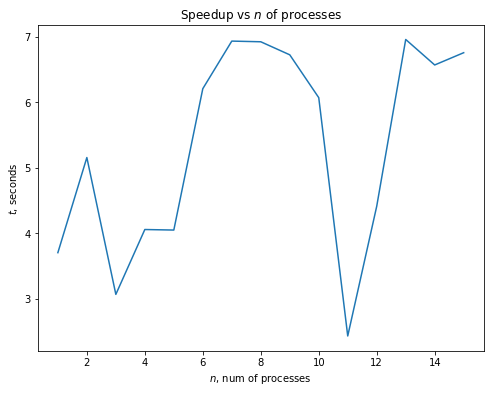

In [14]:
import matplotlib.pyplot as plt
import numpy as np

_, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.arange(1, 16), speedup)

ax.set_title('Speedup vs $n$ of processes')
ax.set_ylabel('$t$, seconds')
ax.set_xlabel('$n$, num of processes')

plt.show()

Strangely the speedup is not linear especially for odd number of processes I believe its due to memory allocation 

In [15]:
from IPython.core.display import Image

In [16]:
Image(url='bif_map.gif')